# Time series forecasting with Tensorflow + Milestone Project 3: BitPredict 💰  

Let's write some Tensorflow code to predict the price of Bitcoin based historical data.

⚠ **Note:** This is not financial advice.

## Get data  

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: [yfinance](https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1629396500&period2=1660932500&interval=1d&events=history&includeAdjustedClose=true)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-09-01 09:53:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-09-01 09:53:25 (7.34 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

In [ ]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.  
Typically deep learning models usually like lots and lots and lots of samples.  
A smaller number of samples is something you'll often run into with time series data problems.

> 🔑**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


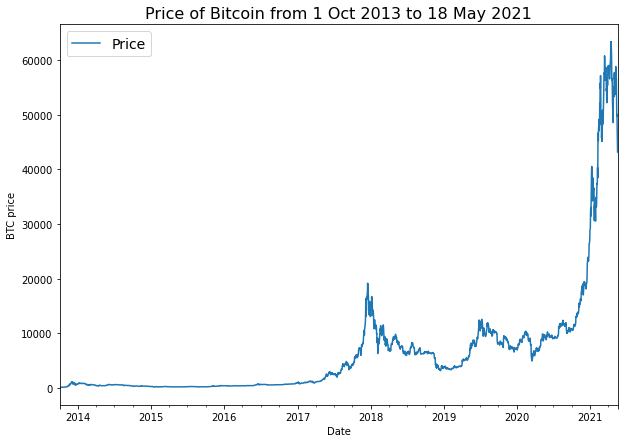

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021",fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv","r") as f:
  csv_reader = csv.reader(f,delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d"))
    btc_price.append(float(line[2])) # get closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

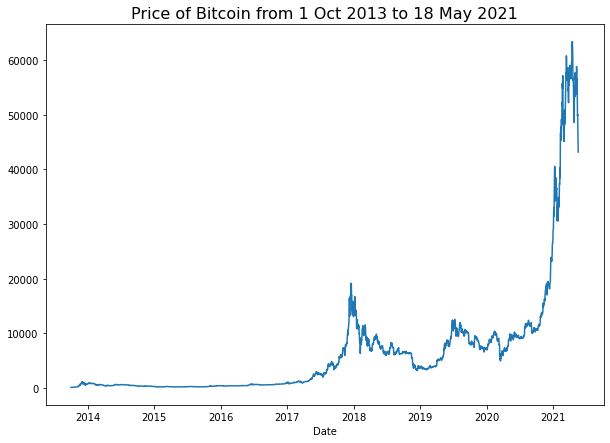

In [ ]:
# Plot from CSV
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021",fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,prices,test_size=0.2,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

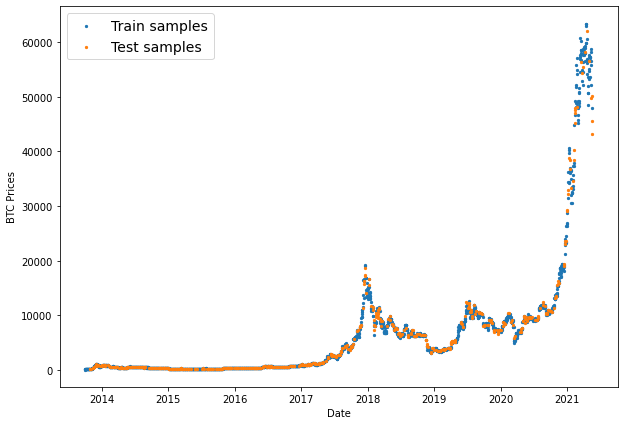

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train samples")
plt.scatter(X_test,y_test,s=5,label="Test samples")
plt.xlabel("Date")
plt.ylabel("BTC Prices")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change tehse values as needed

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2229, 558, 2229, 558)

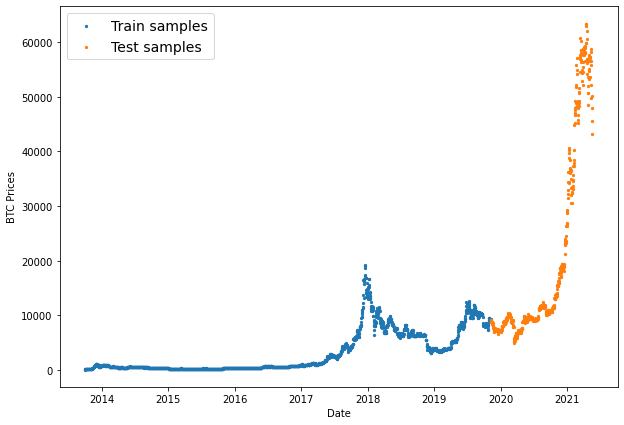

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train samples")
plt.scatter(X_test,y_test,s=5,label="Test samples")
plt.xlabel("Date")
plt.ylabel("BTC Prices")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [ ]:
# Create a function to plot time series data
def plot_btc_time_series(timesteps, values, format=".",start=0,end=None,label=None):
  """
  Plots timesteps ( a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True);

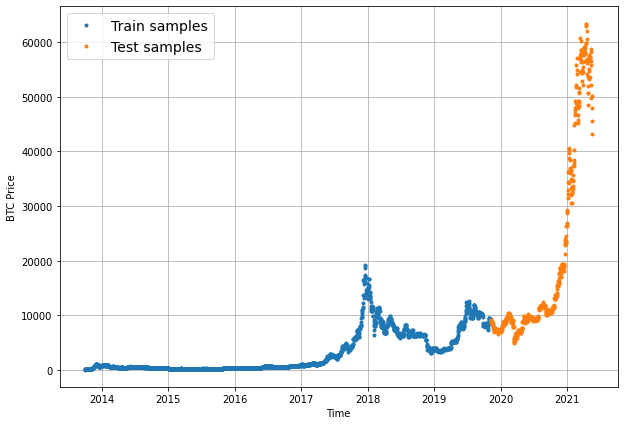

In [ ]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_btc_time_series(timesteps=X_train,values=y_train,label="Train samples")
plot_btc_time_series(timesteps=X_test,values=y_test,label="Test samples")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familier with:
* **Horizon** = number of timesteps into the future we're going to predict.
* **Window size** = number of timesteps we're going to use to predict **horizon**.


| Syntax      | Description |
| :---:       |    :----:   |
| 0      | Naive model (baseline)       |
| 1      | Dense model   horizon = 1, window = 7     |
| 2      | Same as model 1   horizon = 1, window = 30    |
| 3     | Same as model 1   horizon = 7, window = 30   |
| 4      | Conv1D    |
| 5      | LSTM      |
| 6      | Same as model 1 (but with multivariate data)       |
| 7      | N-BEATS algorithm       |
| 8      | Ensembel (multiple models stacked together      |
| 9      | Future prediction model       |
| 10      | Same as model 1 (but with turkey 🦃 data introduced)       |

## Model 0: Naive forecast (baseline)  

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

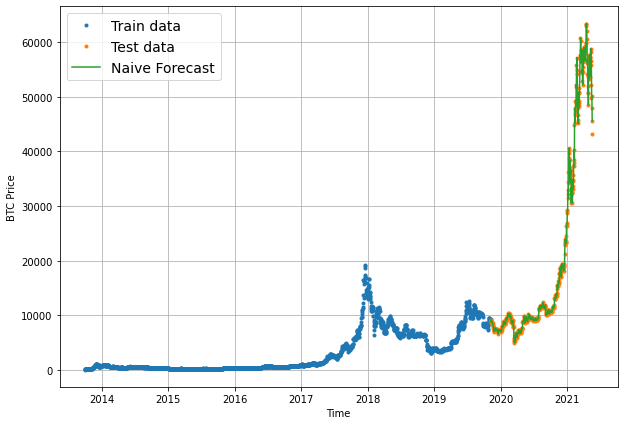

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10,7))
plot_btc_time_series(timesteps=X_train,values=y_train,label="Train data")
plot_btc_time_series(timesteps=X_test,values=y_test,label="Test data")
plot_btc_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluating metrics for time series forecasting.  
What are we doing?  
We're predicting a number, so that means we have a form of a regression problem.  
Because we're working on a regression-like metrics.  
A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE  - mean squared error
* RMSE  - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how our model's forecast (y_pred) compare against the actual values (y_true or ground truth values)?**

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true,y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is of one day, hence the shift of one
  
  return mae/mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:],y_pred=naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation
def evaluate_preds(y_true,y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true,dtype=tf.float32)
  y_pred = tf.cast(y_pred,dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  return {"mae":mae.numpy(),"mse":mse.numpy(),"rmse":rmse.numpy(),"mape":mape.numpy(),"mase":mase.numpy()}

That's one good looking evaluation function!  
Let's now see if it works...

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Format Data part 2: Windowing our dataset

Why do we window?  
We window our time series dataset to turn our data into a suervised learning problem.  
```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make predictions

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6, 7], [7])
  """
  return x[:,:-horizon],x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


## Turning windows into training and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows,labels,test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80/20 splits
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.  
More specifically, we want to compare each of our model's best performances against the other model's best performances.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously used 32)
* 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential(
    [
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="linear")
    ], name="model_1_dense"
)

# 2. Compile
model_1.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae","mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 41ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss: 158.5

In [ ]:
# Load best weights
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense/")

# Evaluate on test set
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecast with a model (on the test data)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
1. Takes in some input data (same kind of data the model was trained on)
1. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Make preidctions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

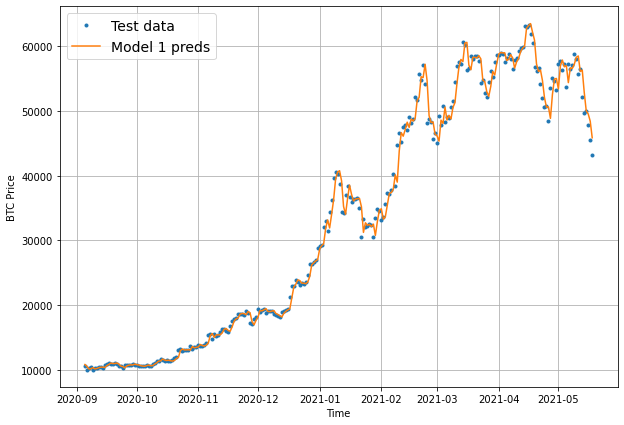

In [ ]:
# Let's plot model 1 predictions
offset=300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_btc_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test data")
plot_btc_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds, start=offset, format="-",label="Model 1 preds")

## Model 2: Dense(window=30, horizon=1)

In [ ]:
HORIZON=1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE=30 # use 30 timesteps in past

In [ ]:
# Make windows data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices,window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential(
    [
      layers.Dense(128,activation="relu"),
      layers.Dense(HORIZON),
    ], name="model_2_dense"
)

# Compile
model_2.compile(loss="mae",
                optimizer="Adam")

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Load in the best weights
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense/")

# Evaluate model 2 on test data
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 605.8741


605.8740844726562

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
# Evaluate predictions for model 2
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

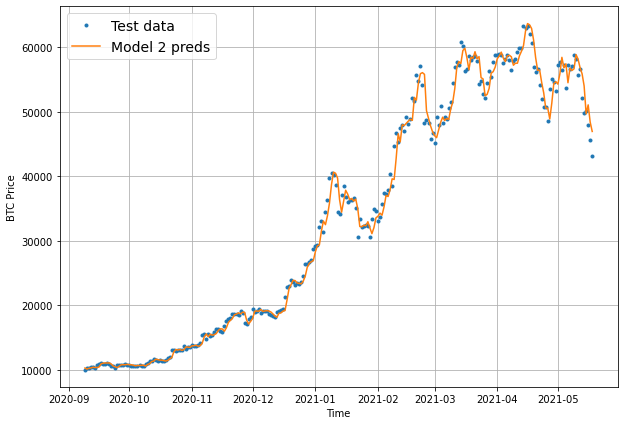

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_btc_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_btc_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-",label="Model 2 preds")

## Model 3: Dense (window=30, horizon=7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                 labels=full_labels)

In [ ]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential(
    [
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON)
    ],name="model_3_dense"
)

# Compile
model_3.compile(loss="mae",
                optimizer="Adam")

# Fit the model
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# Load best version
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense/")

# Evaluate on the test set
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1237.5065


1237.5064697265625

In [ ]:
# Make predictions with model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.891 , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation
def evaluate_preds(y_true,y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true,dtype=tf.float32)
  y_pred = tf.cast(y_pred,dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single dimension)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae":mae.numpy(),"mse":mse.numpy(),"rmse":rmse.numpy(),"mape":mape.numpy(),"mase":mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mse': 5405198.5,
 'rmse': 1425.7478,
 'mape': 5.5588784,
 'mase': 2.2020733}

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

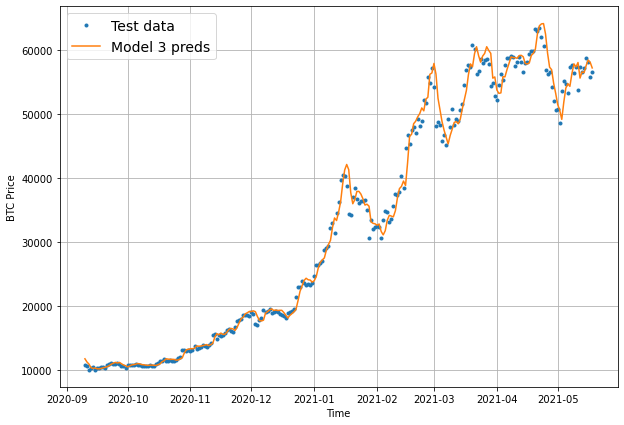

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_btc_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_btc_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis=1), start=offset,format="-", label="Model 3 preds")

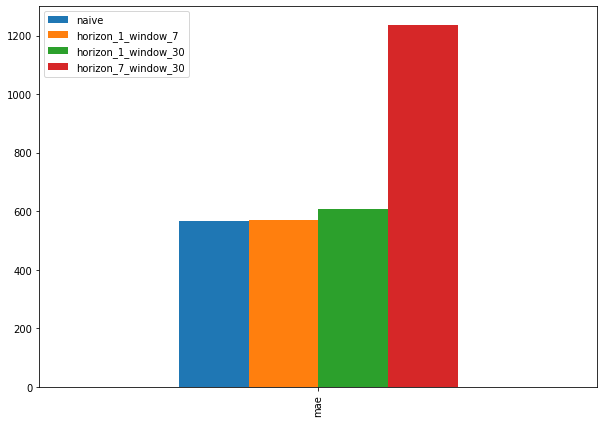

In [ ]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]},index=["mae"]).plot(figsize=(10,7),kind="bar")

> 🔑**Note:** You might be wondering, why are the naive results so good? One of the reasons could be due to the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

## Model 4: Conv1

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows), len(train_labels)

(2224, 2224)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dims)`...  
However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshpae it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # Add and extra dimension for `input_dims`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")

Original shape: (7,)
Expanded shape: (7, 1)


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=7,strides=1, padding="causal",activation="relu"),
    layers.Dense(HORIZON)
],name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer="Adam")

# Fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load the best model
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1D/")

# Evaluate model...
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 570.7388


570.73876953125

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8893.429, 8788.89 , 9020.29 , 8796.402, 8743.089, 8764.085,
       8680.323, 8538.849, 8475.116, 8526.651], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mse': 1183499.9,
 'rmse': 1087.8878,
 'mape': 2.5461204,
 'mase': 1.00263}

## Model 5: RNN (LSTM) 

Let's build a RNN model for our time series data.

We'll use the same data we created previously.

In [ ]:
tf.random.set_seed(42)

# Create the model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

# Compile the model
model_5.compile(loss="mae",
                optimizer="Adam")

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2581.3218 

18/18 [==============================] - 3s 114ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 947.0196 

18/18 [==============================] - 2s 103ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 266.4913

18/18 [==============================] - 3s 149ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 196.5330

18/18 [==============================] - 2s 132ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 170.0374

18/18 [==============================] - 2s 101ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 177.6533

18/18 [==============================] - 2s 118ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 162.8947

18/18 [==============================] - 2s 103ms/step - loss: 162.3369 - val_loss: 877.1690
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 166.4726 - val_loss: 934.8436
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 163.9537 - val_loss: 920.2160
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 148.5054

18/18 [==============================] - 2s 102ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 147.4420 - val_loss: 898.9914
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 151.0533 - val_loss: 943.1418
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 157.8232 - val_loss: 924.0046
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9198 - val_loss: 911.4753
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 155.6456 - val_loss: 862.6680
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 153.1514 - val_loss: 862.5831
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 151.4883 - val_loss: 863.8172
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 150.7770 - val_loss: 886.8356
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 1

18/18 [==============================] - 2s 101ms/step - loss: 146.8467 - val_loss: 845.2782
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 145.1898

18/18 [==============================] - 2s 124ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 153.2509

18/18 [==============================] - 2s 102ms/step - loss: 144.4289 - val_loss: 804.3279
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 142.2844

18/18 [==============================] - 2s 101ms/step - loss: 142.4610 - val_loss: 789.0859
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 141.8739 - val_loss: 806.6758
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 142.0521 - val_loss: 794.8836
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 138.5929

18/18 [==============================] - 2s 103ms/step - loss: 138.4690 - val_loss: 773.2812
Epoch 32/100
 9/18 [==============>...............] - ETA: 0s - loss: 136.8412

18/18 [==============================] - 2s 121ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 135.9342 - val_loss: 786.4805
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 142.0684

18/18 [==============================] - 2s 101ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 133.4513 - val_loss: 756.2970
Epoch 36/100
10/18 [===============>..............] - ETA: 0s - loss: 128.8641

18/18 [==============================] - 2s 101ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 130.6932 - val_loss: 745.9099
Epoch 38/100
12/18 [===================>..........] - ETA: 0s - loss: 133.6792

18/18 [==============================] - 2s 117ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6088 - val_loss: 719.0665
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6111 - val_loss: 732.0632
Epoch 41/100
 9/18 [==============>...............] - ETA: 0s - loss: 137.4434

18/18 [==============================] - 2s 103ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 126.7599

18/18 [==============================] - 2s 104ms/step - loss: 125.6113 - val_loss: 700.8702
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 125.9959 - val_loss: 704.3682
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 124.8729

18/18 [==============================] - 2s 103ms/step - loss: 125.2241 - val_loss: 698.7766
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 121.2221

18/18 [==============================] - 2s 124ms/step - loss: 122.5007 - val_loss: 683.0590
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.0215

18/18 [==============================] - 2s 105ms/step - loss: 124.4726 - val_loss: 679.1873
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 122.1862 - val_loss: 705.4241
Epoch 48/100
11/18 [=================>............] - ETA: 0s - loss: 120.7927

18/18 [==============================] - 2s 103ms/step - loss: 122.0458 - val_loss: 677.0784
Epoch 49/100
10/18 [===============>..............] - ETA: 0s - loss: 129.3385

18/18 [==============================] - 2s 118ms/step - loss: 121.1548 - val_loss: 674.6848
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 122.8890 - val_loss: 691.4816
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 122.2994 - val_loss: 737.3929
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 128.5450

18/18 [==============================] - 2s 102ms/step - loss: 121.2944 - val_loss: 657.2365
Epoch 53/100
10/18 [===============>..............] - ETA: 0s - loss: 114.9636

18/18 [==============================] - 2s 103ms/step - loss: 119.7668 - val_loss: 652.7970
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.1222 - val_loss: 654.4439
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 125.5305

18/18 [==============================] - 2s 100ms/step - loss: 119.2566 - val_loss: 647.2831
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 122.4764

18/18 [==============================] - 2s 120ms/step - loss: 120.0544 - val_loss: 643.7808
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 123.1243 - val_loss: 671.1797
Epoch 58/100
11/18 [=================>............] - ETA: 0s - loss: 120.3613

18/18 [==============================] - 2s 101ms/step - loss: 118.4059 - val_loss: 640.2656
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 117.7119 - val_loss: 645.3837
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 119.2167

18/18 [==============================] - 2s 103ms/step - loss: 118.5346 - val_loss: 638.7429
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3129 - val_loss: 689.4144
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4350 - val_loss: 748.5565
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1006 - val_loss: 651.8298
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9679 - val_loss: 672.9166
Epoch 65/100
11/18 [=================>............] - ETA: 0s - loss: 120.7008

18/18 [==============================] - 2s 102ms/step - loss: 118.8341 - val_loss: 631.7538
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2212 - val_loss: 634.5445
Epoch 67/100
11/18 [=================>............] - ETA: 0s - loss: 116.1731

18/18 [==============================] - 2s 121ms/step - loss: 116.1580 - val_loss: 623.8932
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5543 - val_loss: 635.4929
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5866 - val_loss: 626.3387
Epoch 70/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8156

18/18 [==============================] - 2s 102ms/step - loss: 114.9188 - val_loss: 619.3181
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - val_loss: 650.9373
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2033 - val_loss: 630.5287
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3612 - val_loss: 623.0369
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0345 - val_loss: 623.0776
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2057 - val_loss: 640.5281
Epoch 76/100
12/18 [===================>..........] - ETA: 0s - loss: 113.1771

18/18 [==============================] - 2s 101ms/step - loss: 114.1402 - val_loss: 614.4062
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5973 - val_loss: 689.8776
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 117.2611 - val_loss: 645.2790
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 110.4640

18/18 [==============================] - 2s 102ms/step - loss: 114.1995 - val_loss: 608.7159
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7125 - val_loss: 614.9222
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3684 - val_loss: 634.8466
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 120.5586

18/18 [==============================] - 2s 122ms/step - loss: 115.9701 - val_loss: 607.8510
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 113.3599 - val_loss: 628.8181
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4113 - val_loss: 628.5579
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 114.8363 - val_loss: 634.7715
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5462 - val_loss: 613.5223
Epoch 87/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3621

18/18 [==============================] - 2s 104ms/step - loss: 112.5059 - val_loss: 604.7603
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 114.8154

18/18 [==============================] - 2s 101ms/step - loss: 111.7706 - val_loss: 601.5748
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8470 - val_loss: 624.0131
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6354 - val_loss: 662.9452
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1836 - val_loss: 636.0310
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1700 - val_loss: 606.0366
Epoch 93/100
12/18 [===================>..........] - ETA: 0s - loss: 114.6568

18/18 [==============================] - 2s 119ms/step - loss: 112.4748 - val_loss: 599.8319
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2637 - val_loss: 601.3256
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 109.0149

18/18 [==============================] - 2s 105ms/step - loss: 111.0185 - val_loss: 597.1485
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3787 - val_loss: 601.1596
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - val_loss: 626.1573
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7326 - val_loss: 601.0142
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 109.1518

18/18 [==============================] - 2s 101ms/step - loss: 110.7480 - val_loss: 594.6030
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - val_loss: 595.9847


In [ ]:
# Load the best model
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM/")

# Evaluate the model
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [ ]:
# Make preidctions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mse': 1267231.9,
 'rmse': 1125.7139,
 'mape': 2.6717565,
 'mase': 1.0445527}

## Make a multivariate time-series dataset  

Before we add a feature to our time series, what is a feature we can use?  
One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0  

What's a better feature to use?  
How about the bitcoin halving events?  
https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

In [ ]:
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


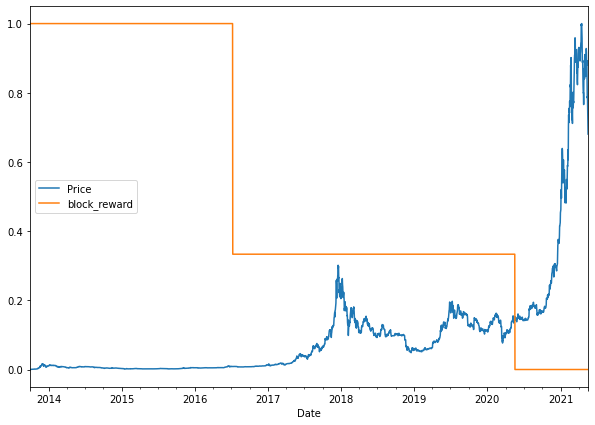

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),columns=bitcoin_prices_block.columns,index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into winowed dataset using helper functions above.  
However, since we've got multivariate data, these functions won't work.  
Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward features
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add the windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.  
```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype('float32')
y = bitcoin_prices_windowed.dropna()["Price"].astype('float32')
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# Make train and test sets using indexing
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Create the multivariate model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON),
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test,y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 56ms/step - loss: 1234.6804 - val_loss: 2061.9077
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 351.5053 - val_loss: 1908.6733
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 208.6112 - val_loss: 1102.1342
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - val_loss: 1107.8474
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 187.2245 - val_loss: 1036.1720
Epoch 7/100
18/18 [==============================] - 1s 42ms/step - loss: 182.0245 - val_loss: 1019.2928
Epoch 8/100
18/18 [==============================] - 0s 27ms/step - loss: 175.7059 - val_loss: 977.8488
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 170.1784 - val_loss: 954.4037
Epoch 10/100
18/18 [==============================] - 0s 

In [ ]:
# Load in the best model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899


567.889892578125

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it performs really well...) time series forecasting model we've built so far.  
Why?
* This will allow us to practice replicating a paper with Tensorflow code
* We will see how to use Tensorflow layer subclassing (to make our own custom layers)
* Get experiance using the Functional API to create a custom architecture
* Potentially get better results

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.  
To create custom layers and models in TensorFlow we can use subclassing.

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int, 
               theta_size: int, 
               horizon: int, 
               n_neurons: int,
               n_layers: int, 
               **kwargs): # The **kwargs takes care of all the arguments for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden  = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")
  
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:,:self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class.  
To do we'll make some dummy inputs and outputs.

In [ ]:
# Setup dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

### Preparing data for the N-BEATS algorithm using `tf.data`
To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the `tf.data` guide.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create NBEATS data inputs (N-BEATS works with univariate time series)

# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bticoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make and train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features,test_labels_dataset))

# Batch and prefetch the data
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair-few number of parameters.

In [ ]:
# Values from the N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE+HORIZON
THETA_SIZE = INPUT_SIZE+HORIZON

### Getting ready for residual connections  
Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).  
The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1,tensor_2])

# Add
added = layers.add([tensor_1,tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

### Building, compiling and fitting the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks).
1. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
1. Make the initial backcast and forecast for the model with the layer created in (1)
1. Use for loop to create stack of block layers.
1. Use the `NBeatsBlock` class within for loop in (4) to create blocks which returns backcasts and block-level forecasts
1. Create the double residual stacking using subtract and add layers.
1. Put the model inputs and outputs together using `tf.keras.Model()`
1. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
1. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create an input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)):

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast],name=f"subtract_{i}")
  forecast = layers.add([forecast,block_forecast],name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile the model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optmizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

In [ ]:
naive_results

Woah... even with all those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.  
This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble  
An ensemble leverages the wisdom of the crowd effect.  
It combines many *different* models to predict a commmon goal.

### Contructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae","mse","mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialise dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optmizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

In [ ]:
# Evaluate the model predictions
ensemble_results = evaluate_preds(y_test,ensemble_preds)
ensemble_results

### Plotting the prediction intervals (uncertainty estimates) of our ensemble  
So far we've been making point predictions with our models.  
E.g. horizon = 1, our model predicts tommorrow's price of Bitcoin will be $50,000 USD  
Wouldn't it be helpful if we knew a range of where that prediction came from?  
Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?  
One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble methods)
1. Measure the standard deviation of the predictions
1. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
1. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean of the predictions made in (1)

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds):
  """
  1. Take the predictions from a number randomly initialized models
  2. Measure the standard deviation of the predictions
  3. Multiply std dev with 1.96 (95% interval)
  4. Get the prediction interval upper and lower bounds
  """
  std = tf.math.reduce_std(preds, axis=0)

  interval = 1.96 * std

  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bound of the 95% prediction interval
lower, upper = get_lower_upper(preds=ensemble_preds)

In [ ]:
# Get the median/mean values of the ensemble preds
ensemble_mean = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the upper and lower fall)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], (lower)[offset:], (upper)[offset:], label="Prediction intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...  
So far all of our models predictions have been lagging behind the test data...  
As in they're replicating what the naive model does and just predict the previous timestep as the next timestep.  
> 🔑 **Note:** These prediction intervals are estimates themselves. They have been created with the assumption that our model's data is from a normal distribution.

## Aside: Two types of uncertainty (coconut and subway)  
Uncertainty estimates in machinne learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
1. What doesn't my model know? (what can a model never predict? or would it be helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not)  

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - This type of uncertainty cannot be reduced and it is often referred as data uncertainty or subway uncertainty.
* **Epistemic uncertainty** - This type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty.

## Model 9: Train a model on the full historical data to make predictions into the future
So far all of our models have predicted on the test dataset, however, this is only a pseudo-future.  
Let's now build a model which is capable of predicting into the future!


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed.head()

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna().["Price"].to_numpy()

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_predict")

# Compile the model
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [ ]:
# How many timesteps to predict into the future
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size the model was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making prediction on `WINDOW_SIZE` sequences which update to remove the first values and append the latest prediction.

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE):
  """
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts
  future_forecasts = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventualy start to make forecasts on its own forecasts)
    future_preds = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecasts
    future_forecasts.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecasts

In [ ]:
# Make forecasts into the future
future_forecasts = make_future_forecasts(values=y_all,
                                         model=model_9,
                                         into_future=INTO_FUTURE,
                                         window_size=WINDOW_SIZE)

### Plot future forecasts

In [ ]:
future_forecasts

In [ ]:
def get_future_dates(start_data, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
# Last timestep of timesteps
last_timestep = bitcoin_prices.index[-1]

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(last_timestep, 0, btc_price[-1])

In [ ]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_price.index, btc_price, start=2500, format="-", label="Actual BTC price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Actual BTC price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]*0.01

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 starts=2500
                 )

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)

### Build a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_models(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer="Adam")
turkey_model.fit(X_train,
                 y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test,y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate the model on test data
model_10 = tf.keras.models.load_model("model_experiments/model_10_turkey_model/")
model_10.evaluate(X_test, y_test)

In [ ]:
# Make predictions
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate preds
turkey_results = evaluate_preds(y_test, turkey_preds)
turkey_results

## Compare models

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_Conv1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_Conv1D": turkey_results}).T
model_results

In [ ]:
# Sort results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar");